## Introduction

This notebook consists of two models, Tiramisu and U-Net, that return segmented images of cars. The images used to train and test the models are from the Carvana Image Masking Challenge on Kaggle. Each car is shot from 16 angles, all with a similar background. For targets, masks, or precise and filled in outlines of the object, have been made of the cars by hand.

The Tiramisu model is based off of the model found here: https://github.com/giovanniguidi/Tiramisu-keras/blob/master/models/model.py. The main advantages of the Tiramisu model are the small number of parameters despite the depth of the model due to primarily using dense layers. The main advantage of the U-Net, in this case, were much shorter runtimes and less overfitting. Both models have advantages over other models such as the VGG16, in Tiramisu's case, by utilizing concatenation of early features to later features within the same block, and, in both, skip connections to save earlier features in later blocks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import os
import cv2

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Data 

In [2]:
df = pd.read_csv('carvana-image-masking-challenge/train_masks.csv')

In [3]:
df.head(2)

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...


In [4]:
df2 = pd.read_csv('carvana-image-masking-challenge/metadata.csv')

In [5]:
df2.head(2)

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech


In [6]:
from PIL import Image

x = []
y = []
rows, columns = 256, 256
channels = 3
num_imgs = 5088
for i,row in df.iterrows():
    if i >= num_imgs:
        break
    img_id = str(row['img'].split('.')[0])
    img = cv2.imread('carvana-image-masking-challenge/train/{}.jpg'.format(img_id))
    img = cv2.resize(img, (rows, columns))
    img = np.asarray(img).astype('float32')
    img /= 255.0
    
    file = 'carvana-image-masking-challenge/train_masks/' + img_id + '_mask.gif'
    new_file = file.split('/')[-1][:-4] + '.jpg'
    Image.open(file).convert('RGB').save(new_file)
    mask = cv2.imread(new_file, 0)
    mask = cv2.resize(mask, (rows, columns))
    mask = np.asarray(mask).astype('float32')
    mask /= 255.0
    
    x.append(img)
    y.append(mask)

In [7]:
x_low_res = []
y_low_res = []
rows, columns = 64, 64
channels = 3
num_imgs = 5088
for i,row in df.iterrows():
    if i >= num_imgs:
        break
    img_id = str(row['img'].split('.')[0])
    img = cv2.imread('carvana-image-masking-challenge/train/{}.jpg'.format(img_id))
    img = cv2.resize(img, (rows, columns))
    img = np.asarray(img).astype('float32')
    img /= 255.0
    
    file = 'carvana-image-masking-challenge/train_masks/' + img_id + '_mask.gif'
    new_file = file.split('/')[-1][:-4] + '.jpg'
    Image.open(file).convert('RGB').save(new_file)
    mask = cv2.imread(new_file, 0)
    mask = cv2.resize(mask, (rows, columns))
    mask = np.asarray(mask).astype('float32')
    mask /= 255.0
    
    x_low_res.append(img)
    y_low_res.append(mask)

## Image Samples

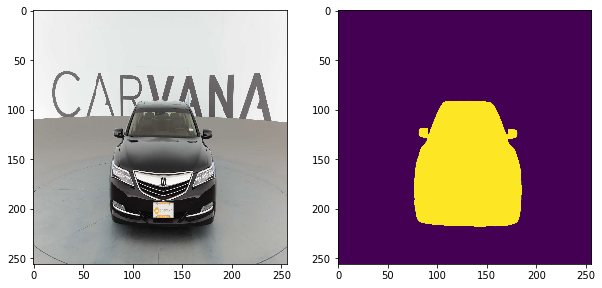

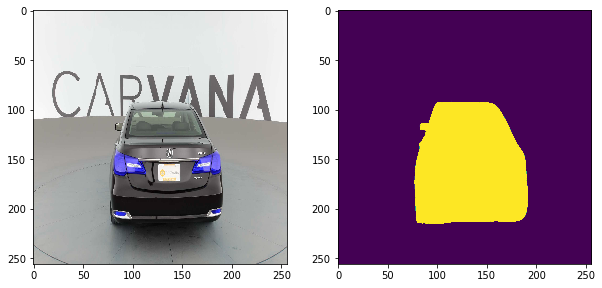

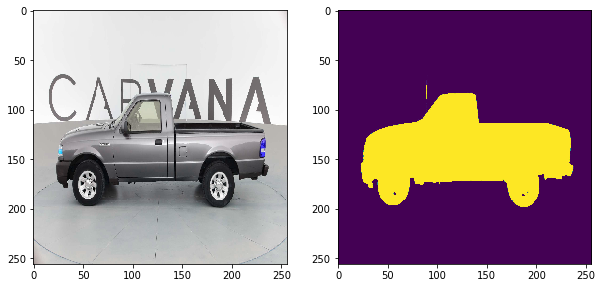

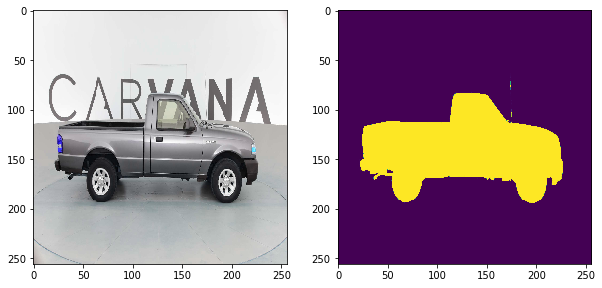

In [8]:
for i in (0, 8, 100, 108):
    plt.figure(figsize = (10, 6))
    plt.subplot(121)
    plt.imshow(x[i])

    plt.subplot(122)
    plt.imshow(y[i])

    plt.show()

## Analysis

In [9]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model 
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, concatenate, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [10]:
x = np.array(x)
y = np.array(y)
y = y.reshape(num_imgs, 256, 256, 1)
x.shape, y.shape

((5088, 256, 256, 3), (5088, 256, 256, 1))

In [11]:
x_low_res = np.array(x_low_res)
y_low_res = np.array(y_low_res)
y_low_res = y_low_res.reshape(num_imgs, 64, 64, 1)
x_low_res.shape, y_low_res.shape

((5088, 64, 64, 3), (5088, 64, 64, 1))

In [12]:
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(y_true * y_pred)
    return (2 * intersection + smooth) / ((K.sum(y_true) + K.sum(y_pred)) + smooth)
def bce_dice_loss(y_true, y_pred):
    return .5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## Tiramisu

In [13]:
# based off of https://github.com/giovanniguidi/Tiramisu-keras/blob/master/models/model.py
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation, Conv2DTranspose, Add, concatenate
from keras.models import model_from_json
from keras.regularizers import l2

class Model_Tiramisu():
    
    def __init__(self):
        self.model = self.build_model()
        print(self.model.summary())
        
    def fit_model(self, x, y, epochs = 10, validation_split = .05): 
        self.model.fit(x, y, epochs = epochs,
                       validation_split = validation_split,
                       workers = 6)

    def build_model(self):
        layer_per_block = [1, 1, 1, 2, 2, 3, 7, 5, 4, 3, 2]
        
        model = self.build_graph(layer_per_block, n_pool=5, growth_rate=16)    

        model.compile(loss = [bce_dice_loss], optimizer = Adam(lr = 0.0005), metrics = [dice_coef])

        return model

    def denseBlock(self, t, nb_layers):
        for _ in range(nb_layers):
            tmp = t
            t = BatchNormalization(axis = -1,
                                    gamma_regularizer = l2(0.0001),
                                    beta_regularizer = l2(0.0001))(t)

            t = Activation('relu')(t)
            t = Conv2D(16, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_uniform', data_format = 'channels_last')(t)
            t = Dropout(0.2)(t)
            t = concatenate([t, tmp])
        return t

    def transitionDown(self, t, nb_features):
        t = BatchNormalization(axis = -1,
                               gamma_regularizer = l2(0.0001),
                               beta_regularizer = l2(0.0001))(t)
        t = Activation('relu')(t)
        t = Conv2D(nb_features,
                   kernel_size = (1, 1),
                   padding = 'same',
                   kernel_initializer = 'he_uniform',
                   data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = MaxPooling2D(pool_size = (2, 2),
                         strides = 2,
                         padding = 'same',
                         data_format = 'channels_last')(t)
        
        return t

    def build_graph(self, layer_per_block, n_pool = 3, growth_rate = 16):
        input_layer = Input(shape = (64, 64, 3))
        t = Conv2D(16, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(input_layer)

        #dense block
        nb_features = 32
        skip_connections = []
        for i in range(n_pool):
            t = self.denseBlock(t, layer_per_block[i])
            skip_connections.append(t)
            nb_features += growth_rate * layer_per_block[i]
            t = self.transitionDown(t, nb_features)

        t = self.denseBlock(t, layer_per_block[n_pool]) # bottle neck

        skip_connections = skip_connections[::-1] #subvert the array

        for i in range(n_pool):
            keep_nb_features = growth_rate * layer_per_block[n_pool + i]
            t = Conv2DTranspose(keep_nb_features, strides=2, kernel_size=(3, 3), padding='same', data_format='channels_last')(t) # transition Up
            t = concatenate([t, skip_connections[i]])

            t = self.denseBlock(t, layer_per_block[n_pool + i + 1])

        t = Conv2D(8, kernel_size=(1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        output_layer = Conv2D(1, 1, activation = 'sigmoid')(t)

        return Model(inputs = input_layer, outputs = output_layer)

In [14]:
model = Model_Tiramisu()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 16)   64          conv2d_1[0][0]                   
_________________________________________________________________________

In [15]:
model_run = model.fit_model(x_low_res, y_low_res)

Train on 4833 samples, validate on 255 samples
Epoch 1/10
4833/4833 [==============================] - 345s 71ms/step - loss: -0.2999 - dice_coef: 0.8971 - val_loss: 0.3409 - val_dice_coef: 0.5098
Epoch 2/10
4833/4833 [==============================] - 339s 70ms/step - loss: -0.4553 - dice_coef: 0.9515 - val_loss: 0.1104 - val_dice_coef: 0.6004
Epoch 3/10
4833/4833 [==============================] - 338s 70ms/step - loss: -0.5320 - dice_coef: 0.9605 - val_loss: -0.2695 - val_dice_coef: 0.7822
Epoch 4/10
4833/4833 [==============================] - 339s 70ms/step - loss: -0.5947 - dice_coef: 0.9648 - val_loss: -0.4882 - val_dice_coef: 0.8819
Epoch 5/10
4833/4833 [==============================] - 340s 70ms/step - loss: -0.6505 - dice_coef: 0.9682 - val_loss: -0.5725 - val_dice_coef: 0.9049
Epoch 6/10
4833/4833 [==============================] - 341s 71ms/step - loss: -0.6984 - dice_coef: 0.9705 - val_loss: -0.5961 - val_dice_coef: 0.8981
Epoch 7/10
4833/4833 [===========================

## U-Net

In [22]:
rows = 256
columns = 256

def unet(input_size = (rows, columns, 3)):
    input_ = Input(input_size)
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_)
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    pool0 = MaxPooling2D(pool_size = (2, 2))(conv0)
    
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    
    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
                                                                                                  
    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    up10 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))

    conv10 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up10)
    conv11 = Conv2D(1, 1, activation = 'sigmoid')(conv10)

    model = Model(input = input_, outputs = conv11)
    
    model.compile(optimizer = Adam(lr = 0.0001),
                  loss = [bce_dice_loss],
                  metrics = [dice_coef])
    
    return model

In [23]:
model = unet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 256, 256, 8)  584         conv2d_67[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_68[0][0]                  
____________________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [26]:
# Fit the model to the training set and compute dice coefficient at each validation set#
model_save = ModelCheckpoint('best_model.hdf5',
                             save_best_only = True,
                             monitor = 'bce_dice_loss',
                             mode = 'min')

model_run = model.fit(x, y,
                      epochs = 10,
                      validation_split = .2,
                      callbacks=[model_save],
                      workers = 6)

model.save("saved_model.h5")

Train on 4070 samples, validate on 1018 samples
Epoch 1/10
4070/4070 [==============================] - 426s 105ms/step - loss: -0.6979 - dice_coef: 0.7958 - val_loss: -0.8343 - val_dice_coef: 0.8973
Epoch 2/10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with bce_dice_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


4070/4070 [==============================] - 408s 100ms/step - loss: -0.9021 - dice_coef: 0.9352 - val_loss: -0.9175 - val_dice_coef: 0.9460
Epoch 3/10
4070/4070 [==============================] - 405s 100ms/step - loss: -0.9254 - dice_coef: 0.9507 - val_loss: -0.9284 - val_dice_coef: 0.9535
Epoch 4/10
4070/4070 [==============================] - 405s 100ms/step - loss: -0.9385 - dice_coef: 0.9592 - val_loss: -0.9409 - val_dice_coef: 0.9619
Epoch 5/10
4070/4070 [==============================] - 405s 100ms/step - loss: -0.9454 - dice_coef: 0.9638 - val_loss: -0.9429 - val_dice_coef: 0.9631
Epoch 6/10
4070/4070 [==============================] - 402s 99ms/step - loss: -0.9493 - dice_coef: 0.9665 - val_loss: -0.9474 - val_dice_coef: 0.9661
Epoch 7/10
4070/4070 [==============================] - 402s 99ms/step - loss: -0.9532 - dice_coef: 0.9690 - val_loss: -0.9497 - val_dice_coef: 0.9680
Epoch 8/10
4070/4070 [==============================] - 402s 99ms/step - loss: -0.9552 - dice_coef: 0

## Visualizations from the U-Net

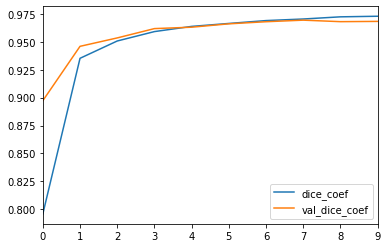

In [33]:
pd.DataFrame(model_run.history)[['dice_coef', 'val_dice_coef']].plot()

In [28]:
y_pred = model.predict(x)

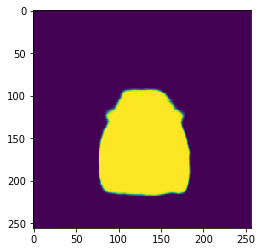

In [29]:
plt.imshow(y_pred[0].reshape(256, 256)) 

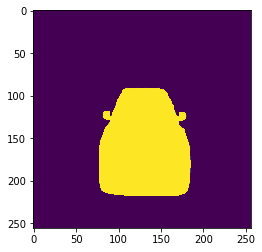

In [30]:
plt.imshow(y[0].reshape(256, 256))

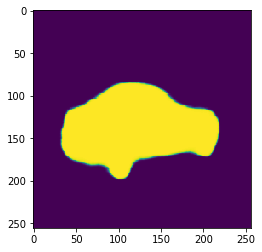

In [31]:
plt.imshow(y_pred[1003].reshape(256, 256))

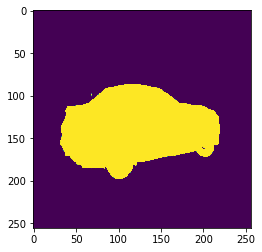

In [32]:
plt.imshow(y[1003].reshape(256, 256)) 

## Next Steps

The accuracy of both models mostly suffered around the external car pieces like the side view mirrors and antennae. There was also some issue with the Tiramisu overfitting, which was partially solved by reducing the learning rate.  Speed still possibly could have been improved by using a data generator, which might also have fixed the remaining overfitting in the Tiramisu model. Nevertheless, Both models were surprisingly fast given the number layers and accuracy achieved. Additionally, the masks generated in the predictions do look like cars.

Further application of these models is possible in augmenting features in image classification models. Currently, those models tend to use features found anywhere in an image, potentially including parts in the background or in the texture of the image. Using features to specifically predict the shape of the target image could help avoid problems in other models, such as incapability of dealing with distortion or rotation of the target object.

I would also like to expand this model to classifying and segmenting other objects. Many useful applications might include crowded images as well, which would mean there would be partially obscured objects. Early epochs of early versions of this U-Net model were able to achieve about 30% accuracy, but that was because all of the cars were in the center of the images. Pictures of the masks generated merely excluded the corners. The model would need to be improved to be able to classify partial images of target objects and objects found in the corners of the image.